# **Google Play Store Apps** - Data Analysis

This notebook includes the procedure of making a descriptive analysis of google play store apps data obtained from [Kaggle](https://www.kaggle.com/datasets/lava18/google-play-store-apps) and cleaned previously.

## 1) Import Libraries

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from IPython.display import display_html
from packaging.version import parse, Version, LegacyVersion
from packaging.utils import canonicalize_version
import os, re, warnings

## 2) Load Dataframes

In [2]:
# load stored dataframes
%store -r

In [4]:
# column subset for shorter view
shorter = ['app', 'category', 'rating', 'reviews', 'size', 'installs', 'type',\
           'price', 'content_rating', 'genres', 'last_updated', 'current_ver',\
           'android_ver']

# full feature dataframe
df_feature[shorter].head(3)

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000,Free,0.0,Everyone,"[Art, Design]",2018-01-07,1,4.0.3
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,"[Pretend Play, Art, Design]",2018-01-15,2,4.0.3
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0.0,Everyone,"[Art, Design]",2018-08-01,1.2.4,4.0.3


In [5]:
# full review dataframe
df_review.head(3)

,app,translated_review,sentiment,sentiment_polarity,sentiment_subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000


In [6]:
# outer merged dataframe
result_outer.head(3)

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,...,update_month,update_day,update_weekday,last_updated,current_ver,android_ver,translated_review,sentiment,sentiment_polarity,sentiment_subjectivity
0,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,"[Pretend Play, Art, Design]",...,1,15,Monday,2018-01-15,2,4.0.3,A kid's excessive ads. The types ads allowed a...,Negative,-0.250,1.000000
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,"[Pretend Play, Art, Design]",...,1,15,Monday,2018-01-15,2,4.0.3,It bad >:(,Negative,-0.725,0.833333
2,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,"[Pretend Play, Art, Design]",...,1,15,Monday,2018-01-15,2,4.0.3,like,Neutral,0.000,0.000000


In [7]:
result_outer.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28250 entries, 0 to 28249
Columns: 21 entries, app to sentiment_subjectivity
dtypes: datetime64[ns](1), float64(4), int64(5), object(11)
memory usage: 4.7+ MB


In [8]:
# average merged dataframe
result_avg.head(3)

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,update_year,update_month,update_day,update_weekday,last_updated,current_ver,android_ver,sentiment,sentiment_polarity,sentiment_subjectivity
0,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,"[Pretend Play, Art, Design]",2018,1,15,Monday,2018-01-15,2,4.0.3,Positive,0.117917,0.645694
1,Garden Coloring Book,ART_AND_DESIGN,4.4,13791,33.0,1000000,Free,0.0,Everyone,"[Art, Design]",2017,9,20,Wednesday,2017-09-20,2.9.2,3,Positive,0.268483,0.523447
2,FlipaClip - Cartoon animation,ART_AND_DESIGN,4.3,194216,39.0,5000000,Free,0.0,Everyone,"[Art, Design]",2018,8,3,Friday,2018-08-03,2.2.5,4.0.3,Positive,0.412649,0.679226


In [9]:
result_avg.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 816 entries, 0 to 815
Columns: 20 entries, app to sentiment_subjectivity
dtypes: datetime64[ns](1), float64(4), int64(5), object(10)
memory usage: 133.9+ KB


## 3) General Analysis

In this section we have reviewed the overall distribution of features and some feature relationships.

### 3.1) Who are the winner? (Using df_feature) (Beste)

__TODO (Possible Suggestion):__ Include a number of reviews column after the merge with averages since it might be important when comparing two samples by sentiment scores!

In [10]:
# function to print the desired columns with number formatting
def print_top(df, col_str, col_num, item_num):
    for i in range(item_num):
        print(df.iloc[i][col_str], ":","{:,}".format(df.iloc[i][col_num]))

In [12]:
# top most downloaded apps:
most_downloaded = df_feature.sort_values(['installs'], ascending=False).head(5)
print_top(most_downloaded,'app','installs',len(most_downloaded))

Google News : 1,000,000,000
Gmail : 1,000,000,000
Google Play Games : 1,000,000,000
YouTube : 1,000,000,000
Google Play Movies & TV : 1,000,000,000


In [13]:
# top most reviewed apps:
highest_review = df_feature.sort_values(['reviews'],ascending=False).head(5)
print_top(highest_review,'app','reviews',len(highest_review))

Facebook : 78,158,306
WhatsApp Messenger : 69,119,316
Instagram : 66,577,313
Messenger – Text and Video Chat for Free : 56,642,847
Clash of Clans : 44,891,723


In [14]:
# top most rated apps:
highest_rated = df_feature.sort_values(['rating'],ascending=False).head(5)
print_top(highest_rated,'app','rating',len(highest_rated))

Brick Breaker BR : 5.0
AJ Men's Grooming : 5.0
Wowkwis aq Ka'qaquj : 5.0
DF Glue Board : 5.0
Clinic Doctor EHr : 5.0


In [15]:
warnings.simplefilter(action='ignore', category=FutureWarning)

### 3.2) General Numeric: The distribution of numerics and their relationships (using result_avg) (Beste)

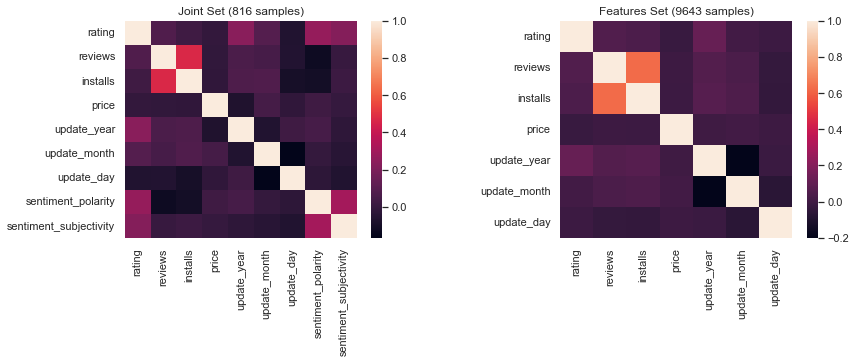

In [16]:
# set seaborn properties
sns.set_theme(style="dark")
sns.set_context('notebook')
sns.set_palette('colorblind')

# plot pairwise correlations
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(13,4))

sns.heatmap(result_avg.corr(), ax=ax0)
ax0.set(title="Joint Set (%i samples)" %len(result_avg))

sns.heatmap(df_feature.corr(), ax=ax1)
ax1.set(title="Features Set (%i samples)" %len(df_feature))

plt.subplots_adjust(wspace=.5)
plt.show();

As we see from the heatmap above; 
- Higher correlation pairs: `reviews-installs`
- Medium correlation pairs: `rating-sentiment_polarity`, `sentiment_polarity-sentiment_subjectivity`
- Lower correlation pairs: `rating-update_year`, `rating-sentiment_subjectivity`
The remaining correlations can be eliminated from performing further analysis pairwise with numeric features.

#### 3.2.1. Reviews VS Installs

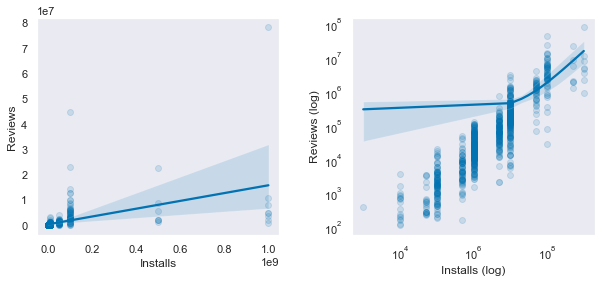

In [17]:
# call regplot on each axes
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(10,4))

# left plot with normal scale
sns.regplot(data=result_avg, y='reviews', x='installs', scatter_kws={'alpha':0.15}, ax=ax0)
ax0.set(xlabel="Installs", ylabel="Reviews")

# right plot with log scale to observe the spread more evenly
sns.regplot(data=result_avg, y='reviews', x='installs', truncate=True, scatter_kws={'alpha':0.15}, ax=ax1)
ax1.set(xlabel="Installs (log)", ylabel="Reviews (log)", xscale="log", yscale="log")

plt.subplots_adjust(wspace=.3)
plt.show();

 - __*Result:*__ We have only confirmed that there is a positive correlation between the installation amount and review amount which was only a known fact.  

#### 3.2.2. Rating VS Correlated Columns

__TODO (Further Analysis):__ We initially expected people to leave more negative comments rather than positive comments since people tend to think negaively or complain more. So it was surprising to see the sentiment score matching the rating, but we have to analyze this further by also onsidering the number of reviews (or the outer merge table may be used to understand sentiment scores more).

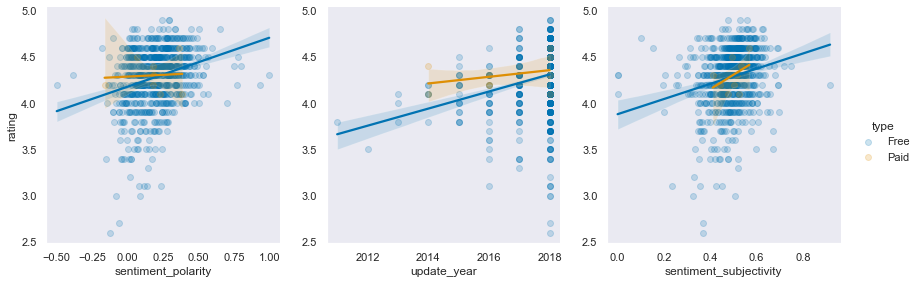

In [22]:
# rating vs sentiment_polarity, update_year and sentiment_subjectivity
x_vars = ['sentiment_polarity', 'update_year', 'sentiment_subjectivity']
y_vars = ['rating']
g = sns.pairplot(data=result_avg, x_vars=x_vars, y_vars=y_vars,
                 hue='type', height=4, kind='reg', plot_kws={'scatter_kws': {'alpha': 0.2}})

# iterate over all subplots to add yticks on each individually
for ax in g.axes.flat:
    ax.tick_params(axis='y', labelleft=True) # method 1
    # ax.yaxis.set_tick_params(labelleft=True) # method 2

plt.subplots_adjust(wspace=.2)
plt.show()

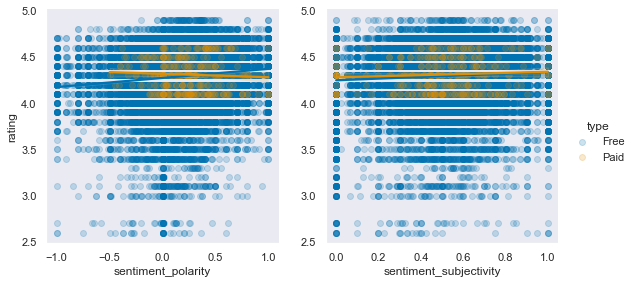

In [23]:
# CASE WHEN ALL SENTIMENT REVIEWS ARE USED SEPARATELLY

# rating vs sentiment_polarity and sentiment_subjectivity
x_vars = ['sentiment_polarity', 'sentiment_subjectivity']
y_vars = ['rating']
g = sns.pairplot(data=result_outer, x_vars=x_vars, y_vars=y_vars,
                 hue='type', height=4, kind='reg', plot_kws={'scatter_kws': {'alpha': 0.2}})

# iterate over all subplots to add yticks on each individually
for ax in g.axes.flat:
    ax.tick_params(axis='y', labelleft=True)

plt.subplots_adjust(wspace=.2)
plt.show()

- __*Result:*__ We have only confirmed that there is a low positive correlation between the rating and sentiment subfields which was only a known fact (we expected an app to be rated higher if the reviews were positive and vice versa). It was rather slightly surprising to confirm the positive corelation between the rating and the update year which made us deduct the fact that:
> __*Keeping an app updated would likely increase the rating.*__


### 3.3) General Categorical: The distribution of categories and their relationships (using result_avg) (Beste)
 
#### 3.3.1. General Distribution of apps per categorical features (by # and %)
__TODO (Fix):__ Also show update month since it makes more sense (weekday can be neglected)

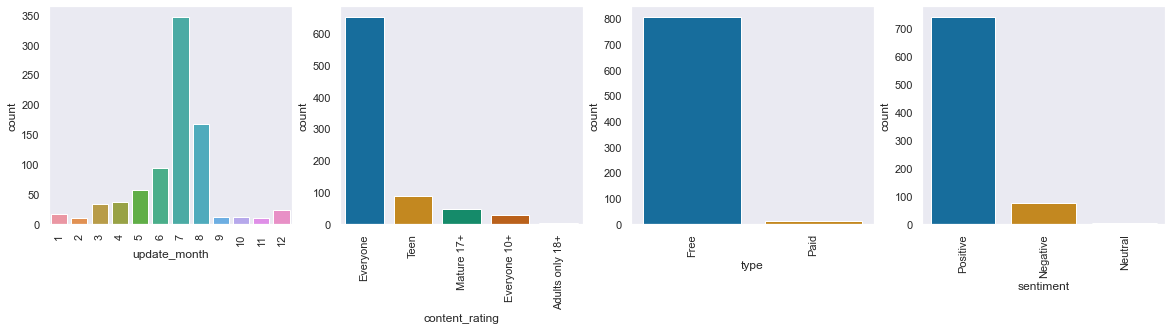

In [64]:
# count plots of selected categorical columns
categorical = ['update_month', 'content_rating', 'type', 'sentiment']

fig, ax = plt.subplots(1, 4, figsize=(20, 4))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(result_avg[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

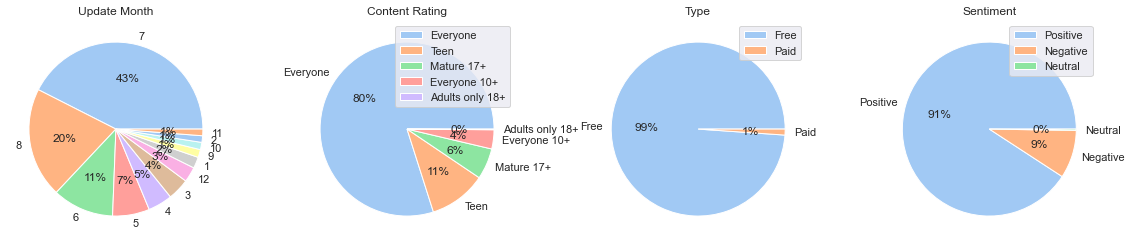

In [65]:
# pie charts of selected categorical columns
categorical = ['update_month', 'content_rating', 'type', 'sentiment']

# define Seaborn color palette to use
colors = sns.color_palette('pastel')

fig, ax = plt.subplots(1, 4, figsize=(20, 4))
for variable, subplot in zip(categorical, ax.flatten()):
    data_plot = result_avg[variable].value_counts()
    subplot.pie(data_plot.values, labels=data_plot.index, colors=colors, autopct='%.0f%%')
    subplot.set(title=variable.replace('_',' ').title())
    if(variable != 'update_month'):
        subplot.legend()

#### 3.3.2. Distribution of apps per category and genre (by # and %)
__TODO (Fix):__ Combine very small slices on pie chart for a cleaner view.

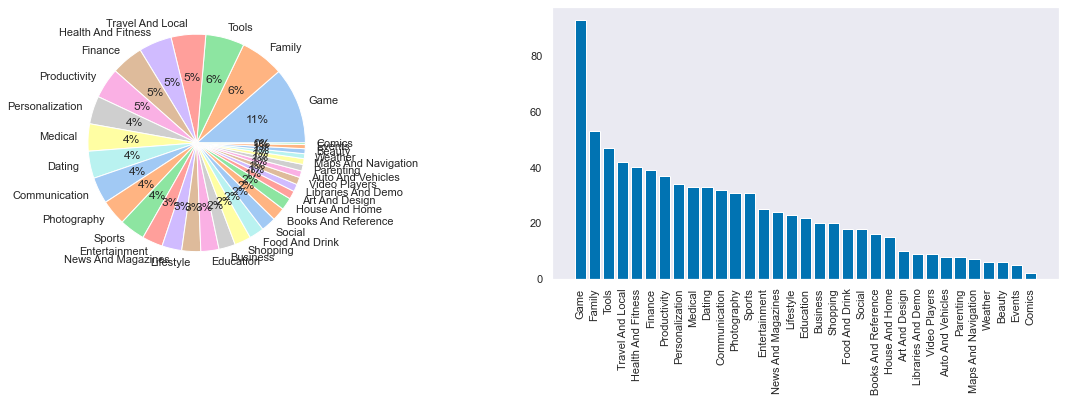

In [63]:
# distribution per app category
data_category = result_avg.category.value_counts()
labels = [item.replace('_', ' ') for item in data_category.index.map(str.title)]

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 5))
ax0.pie(data_category.values, labels=labels, colors=colors, autopct='%.0f%%')
ax1.bar(labels, data_category.values)
for label in ax1.get_xticklabels():
        label.set_rotation(90)
plt.show()

In [ ]:
# distribution per app genres

### 3.4) Categorical and numerical feature relationships? (using result_avg)

## 4) Analysis Questions

In this section we have asked some questions to understand our data better and replied those questions with data analysis and plotting.

### 4.1) Does the update date (day, month) affect the number of installs? (using df_feature) (Beste)

__Question:__ Can we conclude that the apps are likely to be updated on July the most because the users tent to check and install more apps during July (or summer)? Or is it only a developer behavior with no visible affect on installs?

on which months are users more likely to download apps? And which categories? (eg. diet before summer) What could be the reason?

In [66]:
#in which months we have the most download  ---> IS CONSISTENT, but let's check this
df_feature.groupby('update_month')['update_month'].value_counts()

update_month  update_month
1             1                467
2             2                515
3             3                639
4             4                573
5             5                926
6             6               1166
7             7               2610
8             8               1285
9             9                305
10            10               380
11            11               361
12            12               416
Name: update_month, dtype: int64

### 4.2) How does the number of app per category affect? (using ...) (Gaia)

__Question:__ Which category is associated to the most/least number of apps? In the latter case, how are installs and reviews? Does less associated apps = worse quality? Why?

We know from the graphs at section 3.1 that 'game','family' and 'beauty' are the top 3 categories for associated apps. In contrast, 'comics', 'events' and 'weather' are the bottom 3. 

In [ ]:
# display bottom 3 categories in terms of associated apps and check

### 4.3) Price analysis (using ...) (Gaia)

__Question:__ What is the average price for paid apps? 

Use both mean() and median(). There is one or more big outlier(s). Let's see how they affect our statistics and decide whether we want to get rid of it/them or not. (For this specific task, let's use whisker/violin/scatter plots to highlight the outliers (maybe with scatter?) and the std before and after removing them (violin?)).

In [77]:
#try to use the df_feature dataset and get rid of outliers (use std/percentiles) and plot the whole thing again
#creating a sub-dataframe with paid apps only 
paid_apps=df_feature[df_feature.type=='Paid']
paid_apps.head()

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,update_year,update_month,update_day,update_weekday,last_updated,current_ver,android_ver
234,TurboScan: scan documents and receipts in PDF,BUSINESS,4.7,11442,6.8,100000,Paid,4.99,Everyone,[Business],2018,3,25,Sunday,2018-03-25,1.5.2,4
235,Tiny Scanner Pro: PDF Doc Scan,BUSINESS,4.8,10295,39.0,100000,Paid,4.99,Everyone,[Business],2017,4,11,Tuesday,2017-04-11,3.4.6,3
427,Puffin Browser Pro,COMMUNICATION,4.0,18247,Varies,100000,Paid,3.99,Everyone,[Communication],2018,7,5,Thursday,2018-07-05,7.5.3.20547,4.1
476,"Moco+ - Chat, Meet People",DATING,4.2,1545,Varies,10000,Paid,3.99,Mature 17+,[Dating],2018,6,19,Tuesday,2018-06-19,2.6.139,4.1
477,Calculator,DATING,2.6,57,6.2,1000,Paid,6.99,Everyone,[Dating],2017,10,25,Wednesday,2017-10-25,1.1.6,4


In [71]:
#display mean and median of the new dataframe
paid_apps.price.agg(['min','max','mean','median','std'])

min         0.990000
max       400.000000
mean       14.096494
median      2.990000
std        58.855019
Name: price, dtype: float64

<AxesSubplot:xlabel='price'>

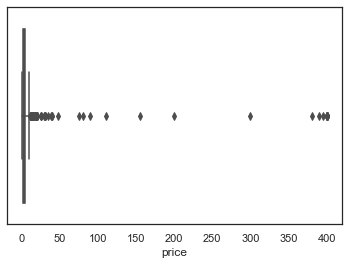

In [69]:
sns.set_theme(style='white')
sns.boxplot(data=paid_apps, x="price")

The difference between mean and median, the huge standard deviation and the boxplot show us that there are a few outliers which drastically affect our price column. For this reason, we decided to get rid of those outliers. If we use the result_avg dataframe instead, we can see that the values are definitely more homogenous.

In [70]:
#using the result_avg dataframe
result_avg.price.agg(['min','max','mean','median','std'])

min        0.000000
max       29.990000
mean       0.099767
median     0.000000
std        1.278179
Name: price, dtype: float64

<AxesSubplot:xlabel='price'>

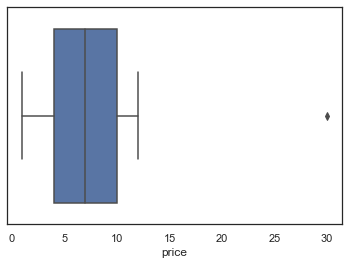

In [72]:
paid_apps=result_avg[result_avg.type=='Paid']
sns.set_theme(style='white')
sns.boxplot(data=paid_apps, x="price")

### 4.4) Why some apps are lagging behind? (using ...) (Gaia)

__Question:__ Which apps were not updated in year 2018? What was the overall sentiment/polarity for those apps? Could it mean they were abandoned? Or that they are going to be improved in the future?

In [78]:
#creating a new sub-dataframe with apps which were not updated in year 2018
not_updated=result_avg[result_avg.update_year!=2018.0]
not_updated.head()

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,update_year,update_month,update_day,update_weekday,last_updated,current_ver,android_ver,sentiment,sentiment_polarity,sentiment_subjectivity
1,Garden Coloring Book,ART_AND_DESIGN,4.4,13791,33.0,1000000,Free,0.0,Everyone,"[Art, Design]",2017,9,20,Wednesday,2017-09-20,2.9.2,3,Positive,0.268483,0.523447
4,Colorfit - Drawing & Coloring,ART_AND_DESIGN,4.7,20260,25.0,500000,Free,0.0,Everyone,"[Creativity, Art, Design]",2017,10,11,Wednesday,2017-10-11,1.0.8,4.0.3,Positive,0.171836,0.572762
21,Beauty Camera - Selfie Camera,BEAUTY,4.0,113715,Varies,10000000,Free,0.0,Everyone,[Beauty],2017,8,3,Thursday,2017-08-03,Varies,Varies,Positive,0.199994,0.450820
23,Dresses Ideas & Fashions +3000,BEAUTY,4.5,473,8.2,100000,Free,0.0,Mature 17+,[Beauty],2017,3,1,Wednesday,2017-03-01,1.0.2,1.6,Positive,0.430603,0.557467
25,Cool Reader,BOOKS_AND_REFERENCE,4.5,246315,Varies,10000000,Free,0.0,Everyone,"[Books, Reference]",2015,7,17,Friday,2015-07-17,Varies,1.5,Positive,0.115841,0.477370


In [74]:
#what is the sentiment over these not updated apps?
not_updated.sentiment.value_counts() / len(not_updated)

Positive    0.89781
Negative    0.10219
Name: sentiment, dtype: float64

In [75]:
#what is the sentiment polarity?
not_updated.sentiment_polarity.agg(['mean','median'])

mean      0.170762
median    0.170372
Name: sentiment_polarity, dtype: float64

### 4.5) Does free=positive reviews and paid=negative reviews? (using ...) (Beste)

__Question:__ Is there an overall correlation between free and positive sentiment or paid and negative sentiment?

In [76]:
free_apps=result_avg[result_avg.type=='Free']
free_apps.head()

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,update_year,update_month,update_day,update_weekday,last_updated,current_ver,android_ver,sentiment,sentiment_polarity,sentiment_subjectivity
0,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,"[Pretend Play, Art, Design]",2018,1,15,Monday,2018-01-15,2,4.0.3,Positive,0.117917,0.645694
1,Garden Coloring Book,ART_AND_DESIGN,4.4,13791,33.0,1000000,Free,0.0,Everyone,"[Art, Design]",2017,9,20,Wednesday,2017-09-20,2.9.2,3,Positive,0.268483,0.523447
2,FlipaClip - Cartoon animation,ART_AND_DESIGN,4.3,194216,39.0,5000000,Free,0.0,Everyone,"[Art, Design]",2018,8,3,Friday,2018-08-03,2.2.5,4.0.3,Positive,0.412649,0.679226
3,Boys Photo Editor - Six Pack & Men's Suit,ART_AND_DESIGN,4.1,654,12.0,100000,Free,0.0,Everyone,"[Art, Design]",2018,3,20,Tuesday,2018-03-20,1.1,4.0.3,Positive,0.260370,0.472593
4,Colorfit - Drawing & Coloring,ART_AND_DESIGN,4.7,20260,25.0,500000,Free,0.0,Everyone,"[Creativity, Art, Design]",2017,10,11,Wednesday,2017-10-11,1.0.8,4.0.3,Positive,0.171836,0.572762


In [79]:
#checking positive, negative and neutral distribution for the free_apps
free_apps.sentiment.value_counts() / len(free_apps) 

Positive    0.908302
Negative    0.089219
Neutral     0.002478
Name: sentiment, dtype: float64

In [80]:
#after deleting the outliers, use the new paid_apps dataset and check the same values
result_avg_paid=result_avg.loc[(result_avg['type']=='Paid')]
result_avg_paid.sentiment.value_counts() / len(result_avg_paid)  

Positive    0.888889
Negative    0.111111
Name: sentiment, dtype: float64

### 4.6) Who are the happiest users? (using ...) (Gaia and Beste)

__Question:__ Is there a specific content ranking category that seems to be expressing more negative sentiment towards apps in general? If so, which one(s)?

In [81]:
#which content rating cateogry has expressed the highest number of ratings
result_avg.groupby(['content_rating'])['rating'].min().sort_values(ascending=False).head(10)

###PEOPLE COMPLAIN. Everyone has lowest min and highest max

content_rating
Adults only 18+    4.5
Everyone 10+       4.0
Teen               3.7
Mature 17+         3.3
Everyone           2.6
Name: rating, dtype: float64

### 4.6) Does the size of the app affect the installs? (using ...) (Gaia and Beste)

__Question:__ Which apps categories (top 5?) have a larger mean size? Are those categories similar or are they totally differnt? Are there outliers or is the distribution homogenous? (great chance o use scatter plots here!) Is there any correlation between the size of the app and the installs? Do people overall prefer installing smaller apps?

In [82]:
#apps with varying sizes!!!
#display the 5 categories with the biggest mean apps size
#We can figure out if having a big sized app can be a disadvantage
biggest_apps=result_avg.sort_values(['category','size'],ascending=False).groupby('category').mean() #why sorting alphabetical??
biggest_apps.head()

,rating,reviews,installs,price,update_year,update_month,update_day,sentiment_polarity,sentiment_subjectivity
category,,,,,,,,,
ART_AND_DESIGN,4.300000,44731.100,2.240000e+06,0.0,2017.800000,5.600000,16.000000,0.243130,0.547018
AUTO_AND_VEHICLES,4.575000,46089.375,1.562500e+06,0.0,2018.000000,6.625000,11.250000,0.266993,0.519421
BEAUTY,4.283333,21858.000,2.033333e+06,0.0,2017.666667,5.833333,10.833333,0.218074,0.485854
BOOKS_AND_REFERENCE,4.343750,282399.750,1.628750e+07,0.0,2017.750000,6.187500,22.000000,0.264134,0.464081
BUSINESS,4.280000,117713.000,8.290000e+06,0.0,2018.000000,6.750000,14.850000,0.218261,0.458500


In [83]:
#display the 5 categories with the smallest mean apps size
smallest_apps=result_avg.sort_values(['category','size'],ascending=False).groupby('category').mean() #why sorting alphabetical??
smallest_apps.tail()

,rating,reviews,installs,price,update_year,update_month,update_day,sentiment_polarity,sentiment_subjectivity
category,,,,,,,,,
SPORTS,4.319355,1.326414e+05,4.643871e+06,0.967419,2017.838710,6.838710,15.806452,0.235871,0.498690
TOOLS,4.295745,1.054740e+06,6.545106e+07,0.000000,2017.617021,6.723404,16.829787,0.214575,0.463516
TRAVEL_AND_LOCAL,4.230952,2.583174e+05,3.390000e+07,0.000000,2017.785714,7.190476,16.523810,0.205629,0.476186
VIDEO_PLAYERS,4.200000,3.003491e+05,9.333333e+06,0.000000,2016.777778,5.888889,17.222222,0.140215,0.473817
WEATHER,4.283333,5.920365e+05,1.950000e+07,0.000000,2017.666667,7.666667,8.833333,0.287789,0.483654


In [ ]:
## scatter plots for size distribution for various categories
#graph per category plot

### 4.7) CONCLUSIONS -  Answers to our preliminary questions:

- Does more downloaded apps have a better rating? <br>
  **No, we couldn't detect any valuable correlation between the two.**
- On which days are users more likely to download apps? On weekend? Or during weekdays? What could be the reason?<br> 
  **Even though we cannot confirm the day the app is downloaded by the user, we saw that the apps updated on Saturday had the highest number of installs.**
  
  ...

## 5) Advanced Analysis

In this section we have worked on a selected business problem and performed a detailed analysis to make a business decision.

**Business objective: creating a medical app. The app should ideally be for users 17+ and NOT free.**

Business analysis: 
- *SWOT analyses (before and after advanced analysis)* 
- *analysis of competitors*
- *analysis of target users*

(This is an extremely simplified business analysis model as you can guess, but we have limited data availability and we do not have a budgeting plan, nor any specific technical requirements for our app - which heavily affects the considerations we can do about business decisions. That being said, I think we have enough points to analyze, given the objective of the project).

IMPORTANT: the competitors' analysis will be heavily reduced, since we can only analyze the "competitive apps" and not the competitive companies. 

In [85]:
# new dataset with ALL medical apps
df_medical = df_feature[df_feature.category=="MEDICAL"]
df_medical.head()

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,update_year,update_month,update_day,update_weekday,last_updated,current_ver,android_ver
2243,Monash Uni Low FODMAP Diet,MEDICAL,4.2,1135,12.0,100000,Paid,9.00,Everyone,[Medical],2018,7,16,Monday,2018-07-16,2.0.7,4
2244,iBP Blood Pressure,MEDICAL,4.4,578,Varies,10000,Paid,0.99,Everyone,[Medical],2014,11,30,Sunday,2014-11-30,7.0.1,2.2
2245,Pedi STAT,MEDICAL,4.6,129,2.9,10000,Paid,5.49,Everyone,[Medical],2018,4,6,Friday,2018-04-06,3.0.1,4.1
2246,ASCCP Mobile,MEDICAL,4.5,63,25.0,10000,Paid,9.99,Everyone,[Medical],2016,10,3,Monday,2016-10-03,2.1.1,2.2
2247,Journal Club: Medicine,MEDICAL,4.8,216,Varies,10000,Paid,6.99,Everyone,[Medical],2017,6,17,Saturday,2017-06-17,Varies,Varies


In [86]:
len(df_medical)

394

In [ ]:
# sample to try other categories
result_avg.sort_values(['installs'], ascending=False).loc[(result_avg.category=="SOCIAL")].head()

df_medical = df_feature.loc[(df_feature.category=="SOCIAL") & (df_feature.type=="Paid")]
len(df_medical)

### 5.1) SWOT Analysis (before advanced analysis)
In this section we will quickly go through the Strenghts, Weaknesses, Opportunities and Threats, based on the information we have gathered through the general analysis of the dataset.

- Strenghts:    to be filled
- Weaknesses:    to be filled 
- Opportunities:   to be filled
- Threads:     to be filled

### 5.2) Competitors' Analysis
- Top rated PAID apps: which categories? Any medical/health app included?

- Top rated PAID medical/health apps: what is the ranking? And the sentiment? Are the users generally happy about those apps?
- Top rated NON PAID medical/health apps: what is the ranking? And the sentiment? Are the users generally happy about those apps? 
- COMPARE THE TWO PREVIOUS POINTS AND DRAW CONCLUSIONS

- Top rated PAID medical/health apps: when were they last updated? With this, we can understand whether these apps are recent or not. We can also check which are the, say, top 3 paid apps that have not been updated in 2017 and figure out if they still exist or not - and therefore if we should consider them as competition or not. 

In [87]:
#create dataframe with paid apps from result_avg dataframe. Sort apps according to rating.
paid_apps_avg=df_feature[df_feature.type=='Paid']
rated_paid_medical= paid_apps_avg[paid_apps_avg.category=='MEDICAL'].sort_values('rating',ascending=False)
rated_paid_medical.head()

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,update_year,update_month,update_day,update_weekday,last_updated,current_ver,android_ver
2271,FHR 5-Tier 2.0,MEDICAL,5.0,2,1.2,500,Paid,2.99,Everyone,[Medical],2015,12,16,Wednesday,2015-12-16,1,4
2262,Super Hearing Secret Voices Recorder PRO,MEDICAL,5.0,3,23.0,100,Paid,2.99,Everyone,[Medical],2018,4,20,Friday,2018-04-20,1,4.1
2297,Hospitalist Handbook,MEDICAL,4.8,12,18.0,1000,Paid,19.99,Everyone,[Medical],2017,6,5,Monday,2017-06-05,6.0.4,4.1
2247,Journal Club: Medicine,MEDICAL,4.8,216,Varies,10000,Paid,6.99,Everyone,[Medical],2017,6,17,Saturday,2017-06-17,Varies,Varies
7899,Radiological Anatomy For FRCR1,MEDICAL,4.8,12,44.0,100,Paid,6.99,Everyone,[Medical],2014,1,22,Wednesday,2014-01-22,1.3,4


### 5.3) Target Users' Analysis
- What is the most common content rating for medical apps? Does it make any sense to restrict it to 17+ or should we review this decision? (also review the various type of content rating

- Is there a correlation between Paid/17+ apps? Or Free/Everyone app? What is the Paid/whichever category below 17 app? So, are 17+ people more willing to spend money for apps?

In [88]:
#Checking most common content rating for medical apps. Perhaps restricting to 17+ is not the wisest choice.
df_medical.content_rating.value_counts() / len(df_medical) 

Everyone        0.954315
Everyone 10+    0.020305
Mature 17+      0.012690
Teen            0.012690
Name: content_rating, dtype: float64

### 5.4) SWOT Analysis (after advanced analysis)
In this section we will list Strenghts, Weaknesses, Opportunities and Threats, based on the information we have gathered through the advanced analysis of the dataset. Afterwards, we can compare our new SWOT analysis to the older one and we can draw conclusions.

- Strenghts:    to be filled
- Weaknesses:    to be filled 
- Opportunities:   to be filled
- Threads:     to be filled

## 6) Conclusions